# Самостоятельный проект. Обучение с учителем: качество модели

**Описание проекта:** \
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель исследование:** \
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход исследования:**
1. Разработайте модель, которая предскажет вероятность снижения покупательской активности.
2. Выделите сегмент покупателей, проанализируйте его и предложите, как увеличить его покупательскую активность. Используйте данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию вы можете проанализировать больше одного сегмента.

**Общий вывод:**
- Предобработка включила в себя исправление опечатки и устранение неявных дубликатов, типы данных в норме и пропущенных значений тоже нет;
- Для поиска лучшей модели использовался случайный поиск кросс-валидации, состоящий из 4 моделей с различными параметрами, главной метрикой выбрана - roc-auc, так как она устойчива, чтобы сравнивать разные модели, не зависит от выбора конкретного порога классификации;
- Лучшая модель - **SVC**;
- Выбранный сегмент: Клиенты с высокой вероятностью снижения активности и высокой прибыльностью (high risk, high profit). Даже внутри прибыльного сегмента большая часть клиентов не генерирует сверхвысокую выручку. Основная масса — "среднеприбыльные", но с высоким риском ухода

**Рекомендации:**

Предложенные действия:
- Запустить персонализированные акции на категории "Товары для детей", "Косметика и аксесуары".
- Добавить ограниченные по времени предложения, чтобы стимулировать срочные покупки.
- Разместить баннеры/рекомендации с упором на товары категории "Товары для детей", "Косметика и аксесуары" на главной странице или в письмах.
- Разместить популярные товары из интересующих категорий на первых 5 страницах.
- Добавить индивидуальные рекомендации на первой странице.



In [1]:
!pip install -q phik
!pip install -q shap
!pip install -q --upgrade scikit-learn

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import shap
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
RANDOM_STATE = 42

## Загрузка данных

In [4]:
def load_df(filename, sep=',', decimal='.'):
    pth1 = "./datasets/" + filename
    pth2 = 'https://code.s3.yandex.net/datasets/' + filename

    if os.path.exists(pth1):
        df = pd.read_csv(pth1, sep=sep, decimal=decimal)
    else:
        df = pd.read_csv(pth2, sep=sep, decimal=decimal)

    print('\n\tПервые строки датафрейма')
    display(df.head())

    print('\n\n\tИнформация о датафрейме\n')
    df.info()

    if not df.select_dtypes(exclude='object').empty:
        print('\n\n\tОписательная статистика о количественных признаках')
        display(df.describe().T)

    if not df.select_dtypes(include='object').empty:
        print('\n\n\tОписательная статистика о качественных признаках')
        display(df.describe(include='object').T)

    return df

In [5]:
market_file = load_df('market_file.csv')


	Первые строки датафрейма


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2




	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ош

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00




	Описательная статистика о качественных признаках


,count,unique,top,freq
Покупательская активность,1300,2,Прежний уровень,802
Тип сервиса,1300,3,стандарт,914
Разрешить сообщать,1300,2,да,962
Популярная_категория,1300,6,Товары для детей,330


In [6]:
market_file.columns = ['id', 'customer_activity', 'service_type', 'allow_notification', 'market_activ_6_month', 'market_activ_curr_month', 'duration', 'promo_buys', 'pop_category', 'mean_categories_views_per_visit', 'unpaid_prod_unit_quarterly', 'service_error', 'pages_per_visit']

---

In [7]:
market_money = load_df('market_money.csv')


	Первые строки датафрейма


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6




	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


	Описательная статистика о количественных признаках


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2




	Описательная статистика о качественных признаках


,count,unique,top,freq
Период,3900,3,препредыдущий_месяц,1300


In [8]:
market_money.columns = ['id', 'period', 'revenue']

---

In [9]:
market_time = load_df('market_time.csv')


	Первые строки датафрейма


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13




	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


	Описательная статистика о количественных признаках


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0




	Описательная статистика о качественных признаках


,count,unique,top,freq
Период,2600,2,текущий_месяц,1300


In [10]:
market_time.columns = ['id', 'period', 'minutes']

---

In [11]:
money = load_df('money.csv', sep=';', decimal=',')


	Первые строки датафрейма


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21




	Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


	Описательная статистика о количественных признаках


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


In [12]:
money.columns = ['id', 'revenue']

**Вывод**

- Названия столбцов переименованы
- Есть неявные дубликаты

Данные загружены успешно, следующий этап предобработка.

## Предобработка данных

In [13]:
def check_dupl_nans(df):
    print('\n\tКоличество полных дубликатов =', df.duplicated().sum())

    columns = df.select_dtypes(include='object').columns.tolist()
    if len(columns) != 0:
        print('\n\tПоиск неявных дубликатов')
        for column in columns:
            print('В столбце', column, 'уникальных значений =', df[column].nunique())
            print('Список уникальных значений =', df[column].unique(), '\n')

    print('\n\tКоличество пропущенных значений')
    print(df.isna().sum())

    print('\n\tТипы данных')
    print(df.dtypes)

### `market_file`

In [14]:
check_dupl_nans(market_file)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце customer_activity уникальных значений = 2
Список уникальных значений = ['Снизилась' 'Прежний уровень'] 

В столбце service_type уникальных значений = 3
Список уникальных значений = ['премиум' 'стандартт' 'стандарт'] 

В столбце allow_notification уникальных значений = 2
Список уникальных значений = ['да' 'нет'] 

В столбце pop_category уникальных значений = 6
Список уникальных значений = ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 


	Количество пропущенных значений
id                                 0
customer_activity                  0
service_type                       0
allow_notification                 0
market_activ_6_month               0
market_activ_curr_month            0
duration                           0
promo_buys                         0
pop_category                       0
mean_catego

In [15]:
market_file['service_type'] = market_file['service_type'].replace('стандартт', 'стандарт')

### `market_money`

In [16]:
check_dupl_nans(market_money)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце period уникальных значений = 3
Список уникальных значений = ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] 


	Количество пропущенных значений
id         0
period     0
revenue    0
dtype: int64

	Типы данных
id           int64
period      object
revenue    float64
dtype: object


### `market_time`

In [17]:
check_dupl_nans(market_time)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце period уникальных значений = 2
Список уникальных значений = ['текущий_месяц' 'предыдцщий_месяц'] 


	Количество пропущенных значений
id         0
period     0
minutes    0
dtype: int64

	Типы данных
id          int64
period     object
minutes     int64
dtype: object


In [18]:
market_time['period'] = market_time['period'].replace('предыдцщий_месяц', 'предыдущий_месяц')

### `money`

In [19]:
check_dupl_nans(money)


	Количество полных дубликатов = 0

	Количество пропущенных значений
id         0
revenue    0
dtype: int64

	Типы данных
id           int64
revenue    float64
dtype: object


**Вывод**
- Полных дубликатов нет, неявные - исправлены
- Исправлена опечатка в `market_time[period]`

## Исследовательский анализ данных

In [20]:
sns.set_theme(style='whitegrid', palette='pastel')
#num_bins = int(np.ceil(np.log2(len(df)) + 1))

In [21]:
def eda_describe_numeric(df, column):
    print(df[column].describe().T)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, bins=int(np.ceil(np.log2(df.shape[0]))))
    plt.title(f'Распределение {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами {column}')
    plt.show()

In [22]:
def eda_describe_categorical(df, column):
    print(df[column].describe(include='object').T)
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[column], order=df[column].value_counts().index)
    plt.title(f"Распределение {column}")
    plt.xticks(rotation=45)
    plt.show()

In [23]:
def eda_describe_feature(df, column):
    print('\n\tОписательная статистика столбца -', column)
    num_col_names = df.select_dtypes(include='number').columns.tolist()
    # для числовых переменных
    if column in num_col_names:
        eda_describe_numeric(df, column)

    # для категориальных переменных
    else:
        eda_describe_categorical(df, column)


### `market_file`

#### `customer_activity`


	Описательная статистика столбца - customer_activity
count                1300
unique                  2
top       Прежний уровень
freq                  802
Name: customer_activity, dtype: object


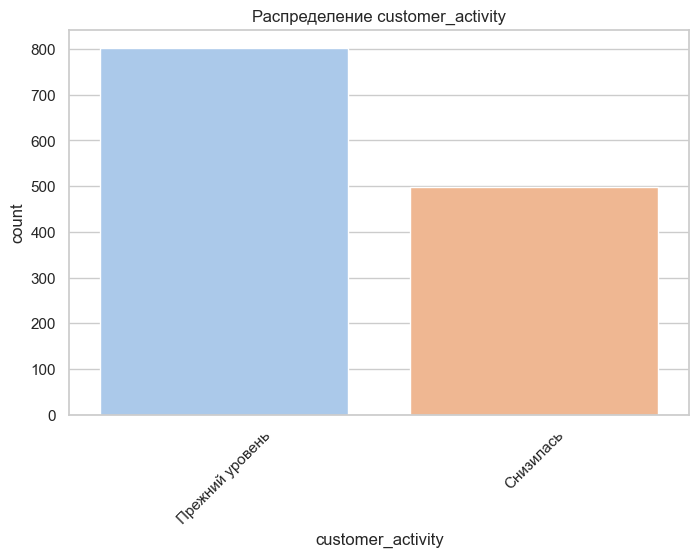

In [24]:
eda_describe_feature(market_file, 'customer_activity')

#### `service_type`


	Описательная статистика столбца - service_type
count         1300
unique           2
top       стандарт
freq           924
Name: service_type, dtype: object


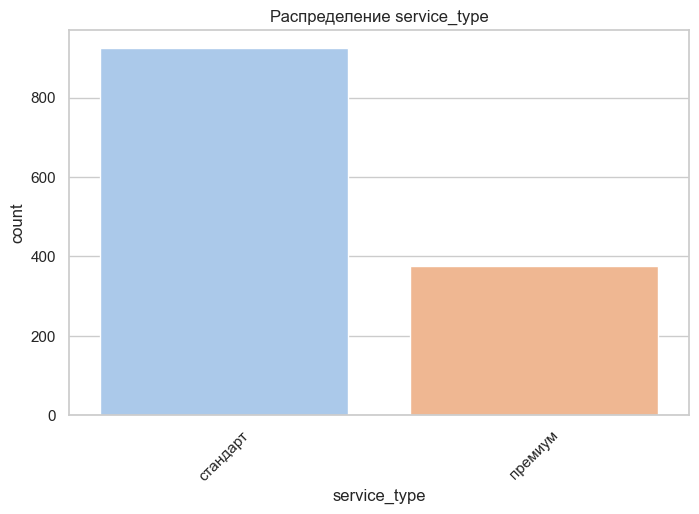

In [25]:
eda_describe_feature(market_file, 'service_type')

#### `allow_notification`


	Описательная статистика столбца - allow_notification
count     1300
unique       2
top         да
freq       962
Name: allow_notification, dtype: object


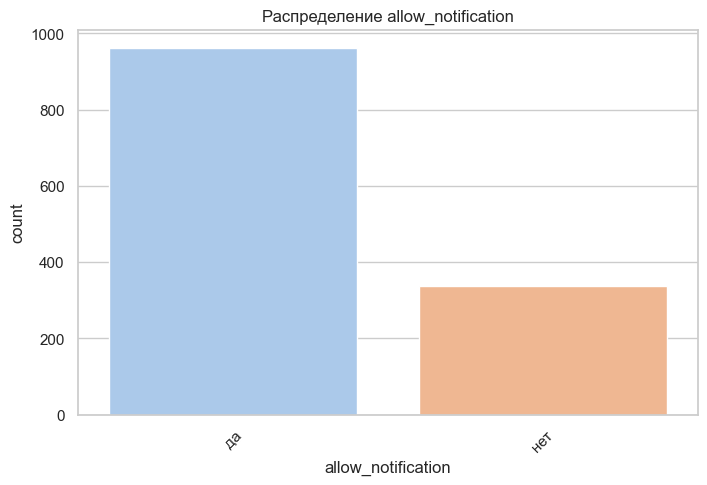

In [26]:
eda_describe_feature(market_file, 'allow_notification')

#### `market_activ_6_month`


	Описательная статистика столбца - market_activ_6_month
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: market_activ_6_month, dtype: float64


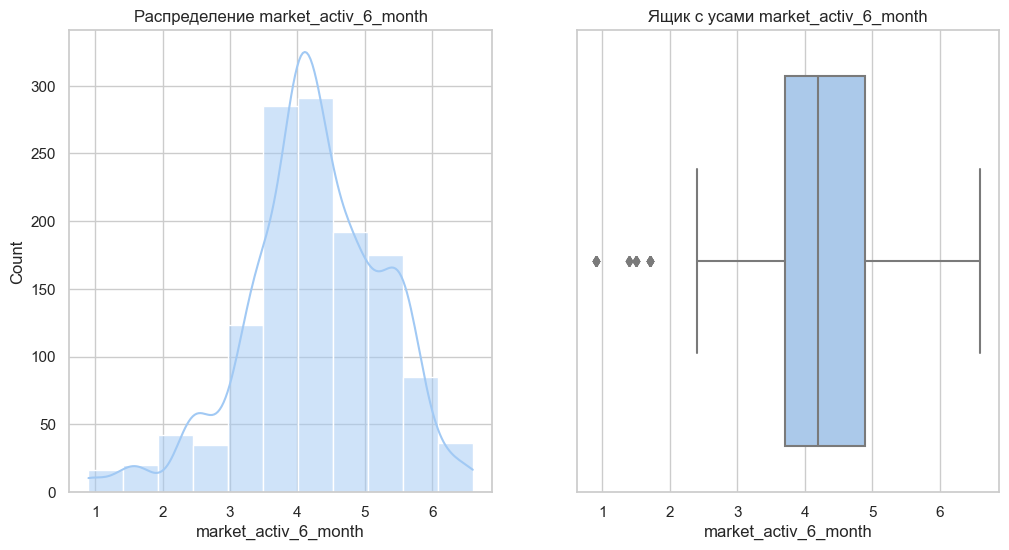

In [27]:
eda_describe_feature(market_file, 'market_activ_6_month')

#### `market_activ_curr_month`


	Описательная статистика столбца - market_activ_curr_month
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: market_activ_curr_month, dtype: float64


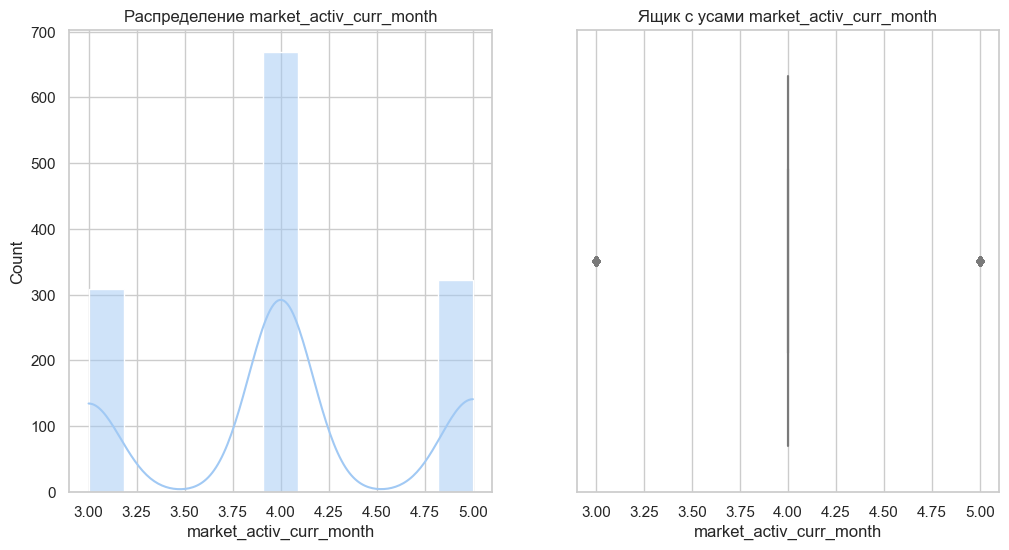

In [28]:
eda_describe_feature(market_file, 'market_activ_curr_month')

По графику видно, что признак распределен мультимодально, можно перевести его в категорию

#### `duration`


	Описательная статистика столбца - duration
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64


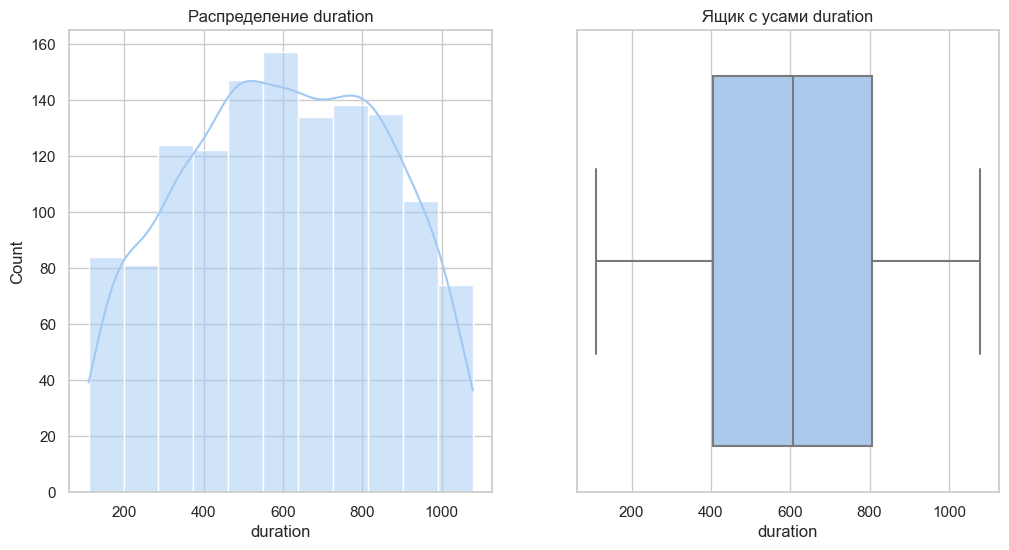

In [29]:
eda_describe_feature(market_file, 'duration')

#### `promo_buys`


	Описательная статистика столбца - promo_buys
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promo_buys, dtype: float64


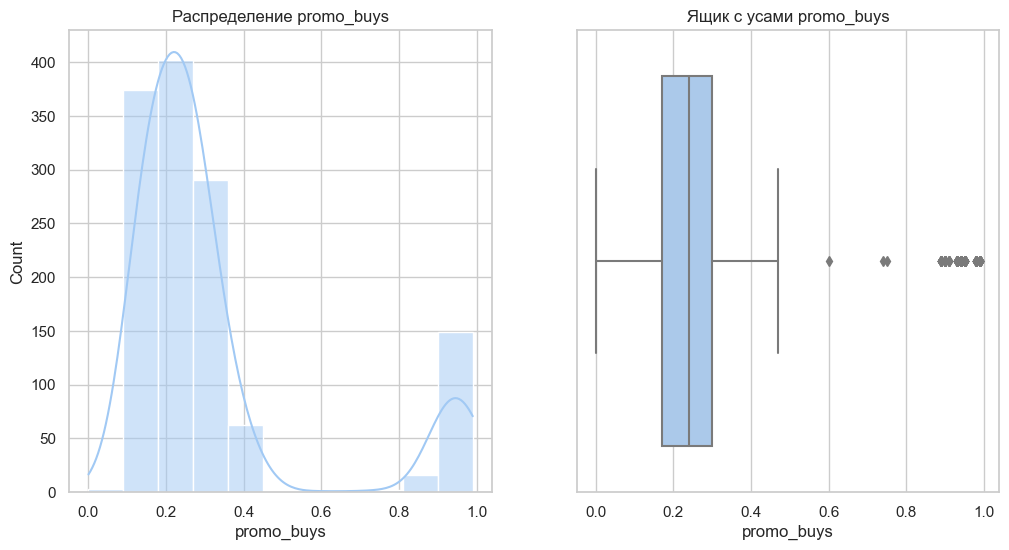

In [30]:
eda_describe_feature(market_file, 'promo_buys')

В этом признаке наблюдается мультимодальность. Создаем новый признак для разделения на категории

In [31]:
market_file['promo_buys_less_0.9'] = (market_file['promo_buys'] < 0.9).astype('int')

#### `pop_category`


	Описательная статистика столбца - pop_category
count                 1300
unique                   6
top       Товары для детей
freq                   330
Name: pop_category, dtype: object


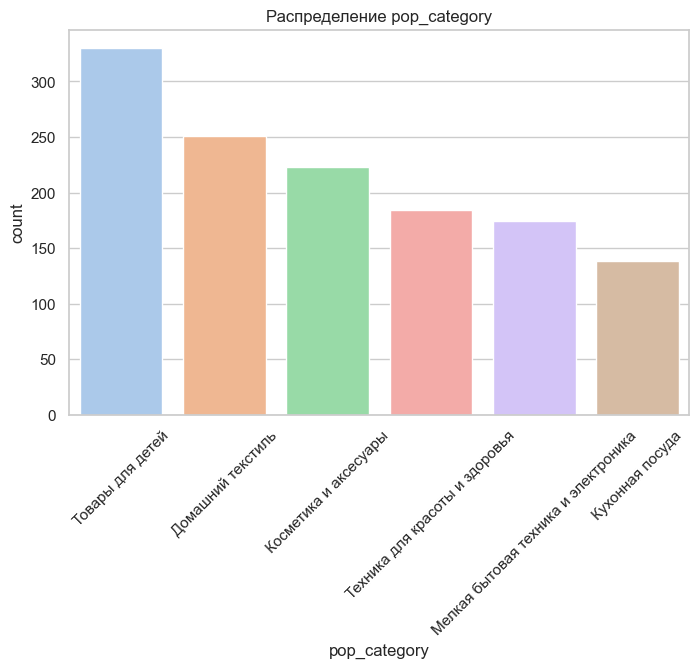

In [32]:
eda_describe_feature(market_file, 'pop_category')

#### `mean_categories_views_per_visit`


	Описательная статистика столбца - mean_categories_views_per_visit
count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: mean_categories_views_per_visit, dtype: float64


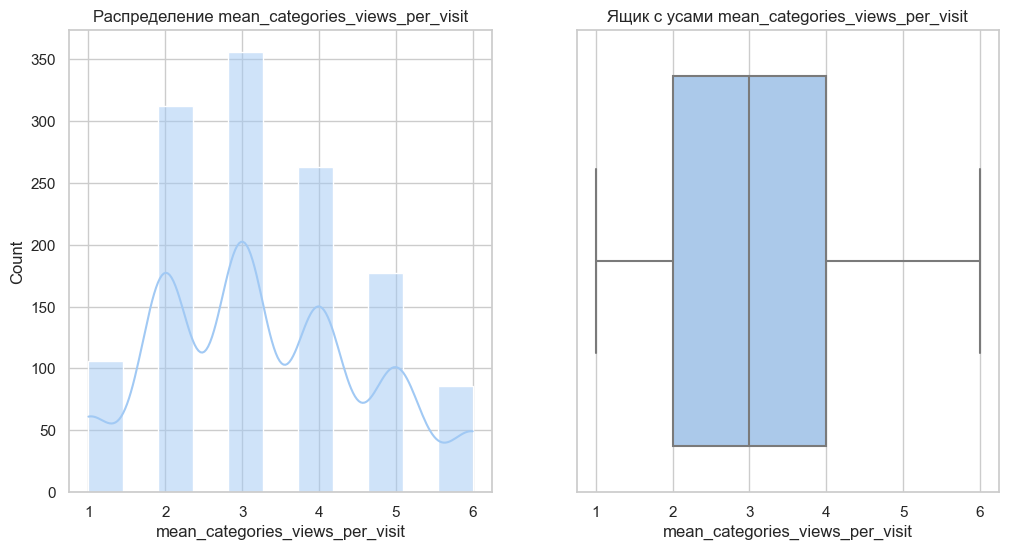

In [33]:
eda_describe_feature(market_file, 'mean_categories_views_per_visit')

#### `unpaid_prod_unit_quarterly`


	Описательная статистика столбца - unpaid_prod_unit_quarterly
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_prod_unit_quarterly, dtype: float64


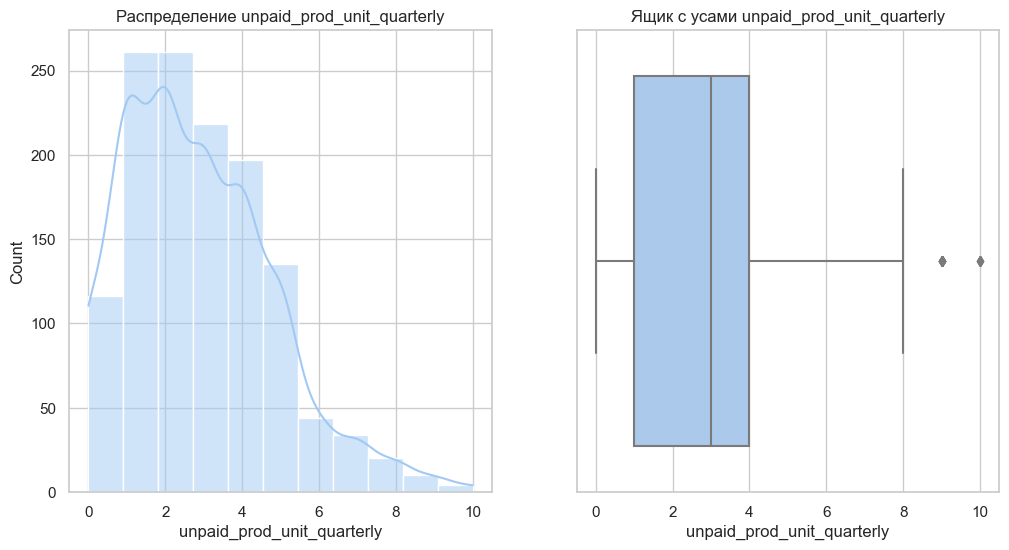

In [34]:
eda_describe_feature(market_file, 'unpaid_prod_unit_quarterly')

Распределение со смещением влево

#### `service_error`


	Описательная статистика столбца - service_error
count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: service_error, dtype: float64


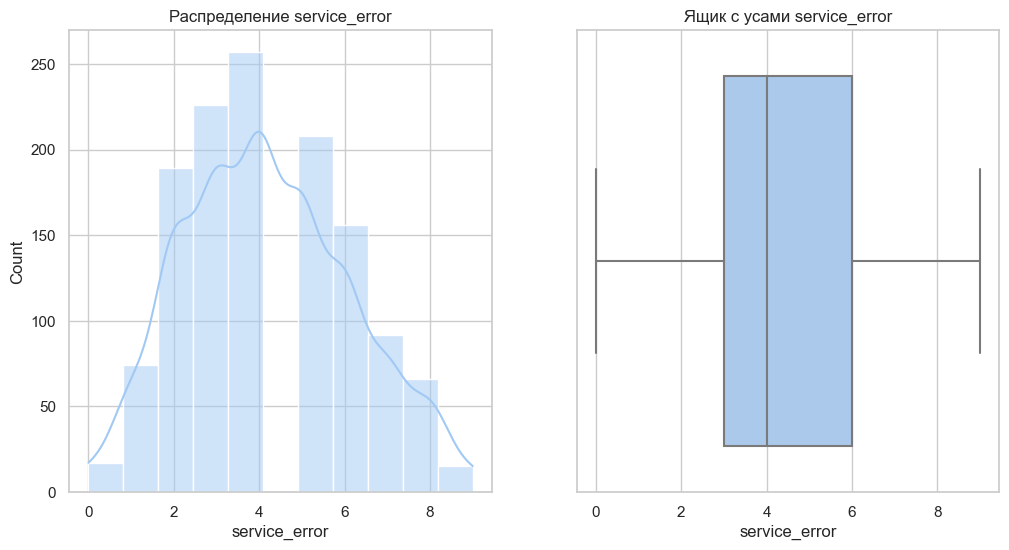

In [35]:
eda_describe_feature(market_file, 'service_error')

#### `pages_per_visit`


	Описательная статистика столбца - pages_per_visit
count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit, dtype: float64


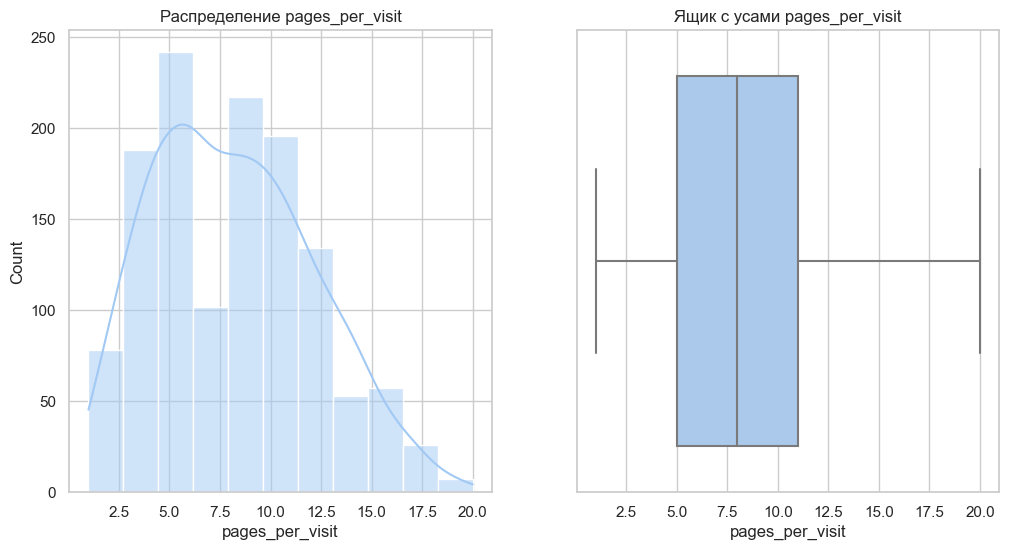

In [36]:
eda_describe_feature(market_file, 'pages_per_visit')

### `market_money`

#### `period`


	Описательная статистика столбца - period
count                    3900
unique                      3
top       препредыдущий_месяц
freq                     1300
Name: period, dtype: object


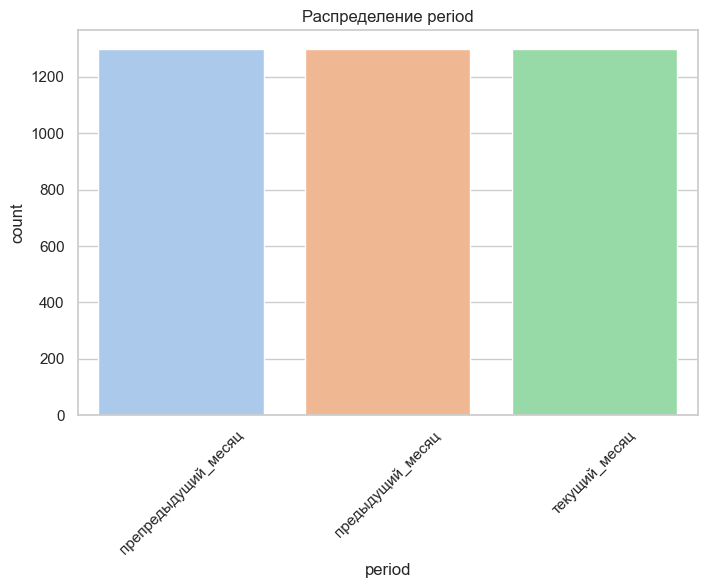

In [37]:
eda_describe_feature(market_money, 'period')

#### `revenue`


	Описательная статистика столбца - revenue
count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64


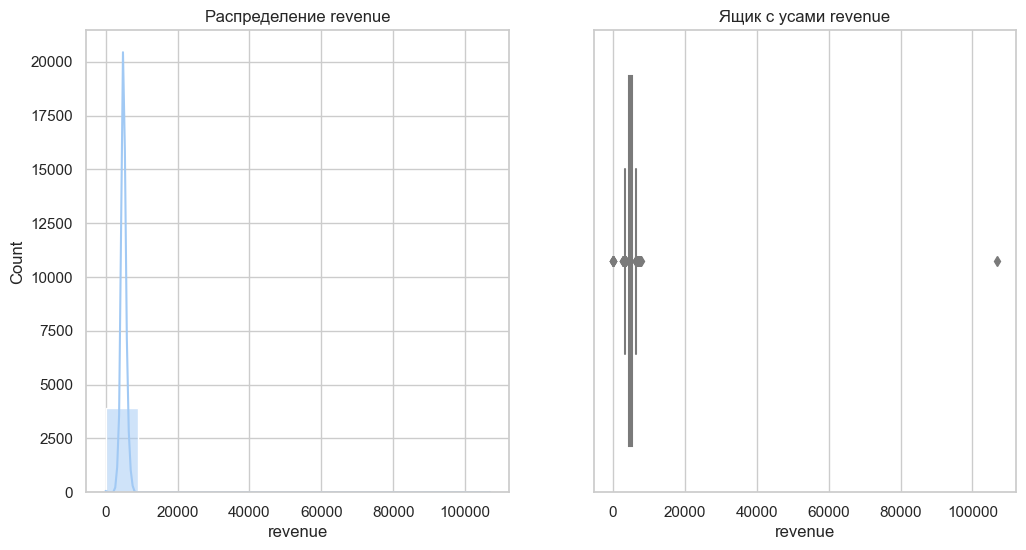

In [38]:
eda_describe_feature(market_money, 'revenue')

Максимальное и минимальное значение являются выбросами, удаляем его

In [39]:
market_money = market_money[(market_money['revenue'] != max(market_money['revenue'])) & (market_money['revenue'] != 0)]


	Описательная статистика столбца - revenue
count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: revenue, dtype: float64


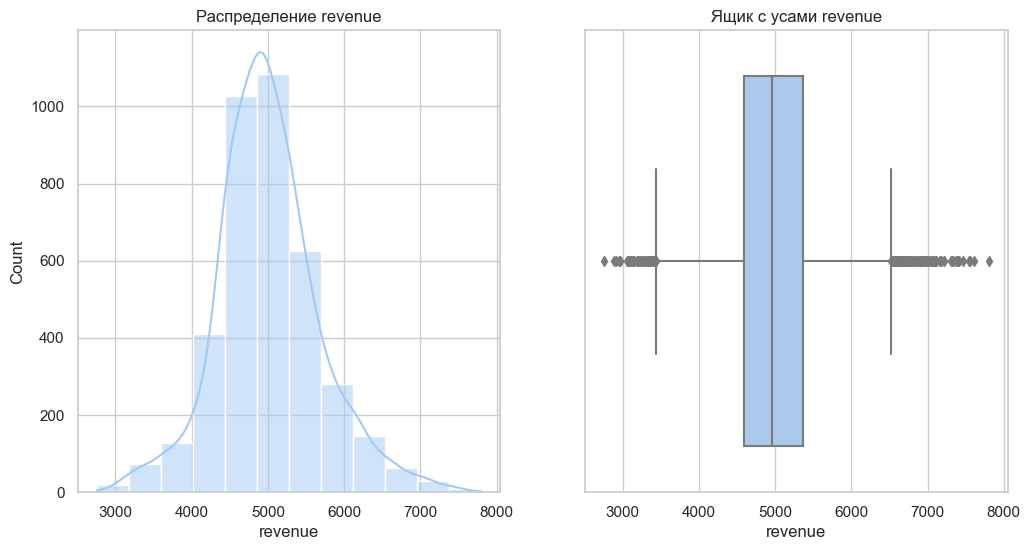

In [40]:
eda_describe_feature(market_money, 'revenue')

### `market_time`

#### `period`


	Описательная статистика столбца - period
count                 2600
unique                   2
top       предыдущий_месяц
freq                  1300
Name: period, dtype: object


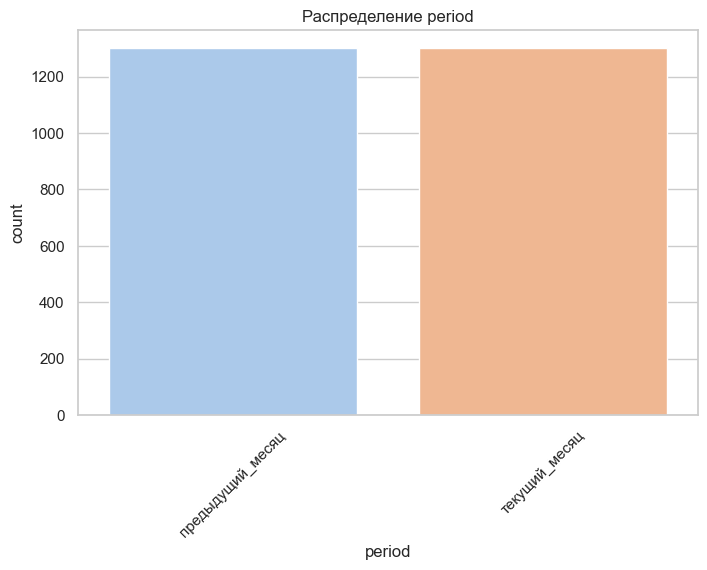

In [41]:
eda_describe_feature(market_time, 'period')

#### `minutes`


	Описательная статистика столбца - minutes
count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64


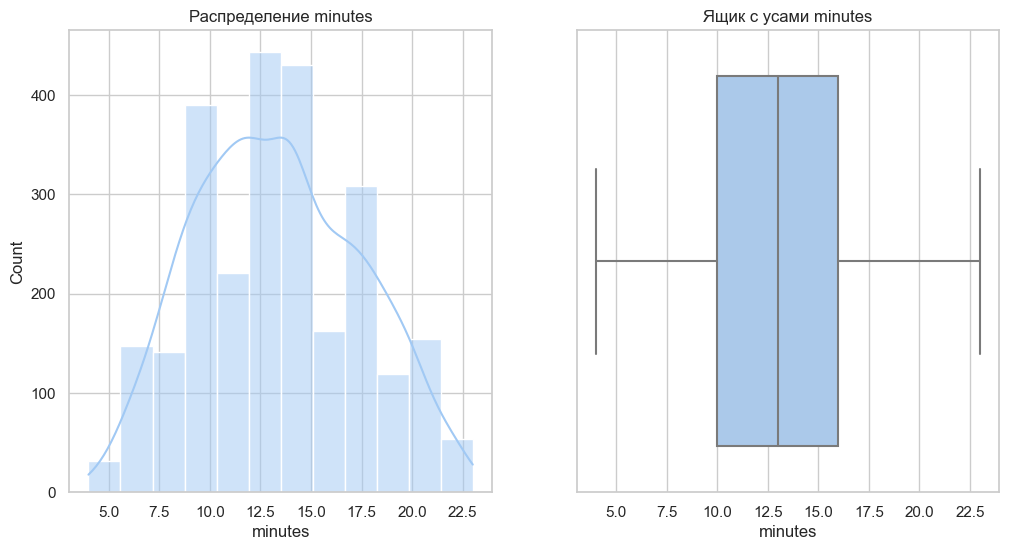

In [42]:
eda_describe_feature(market_time, 'minutes')

### `money`


	Описательная статистика столбца - revenue
count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: revenue, dtype: float64


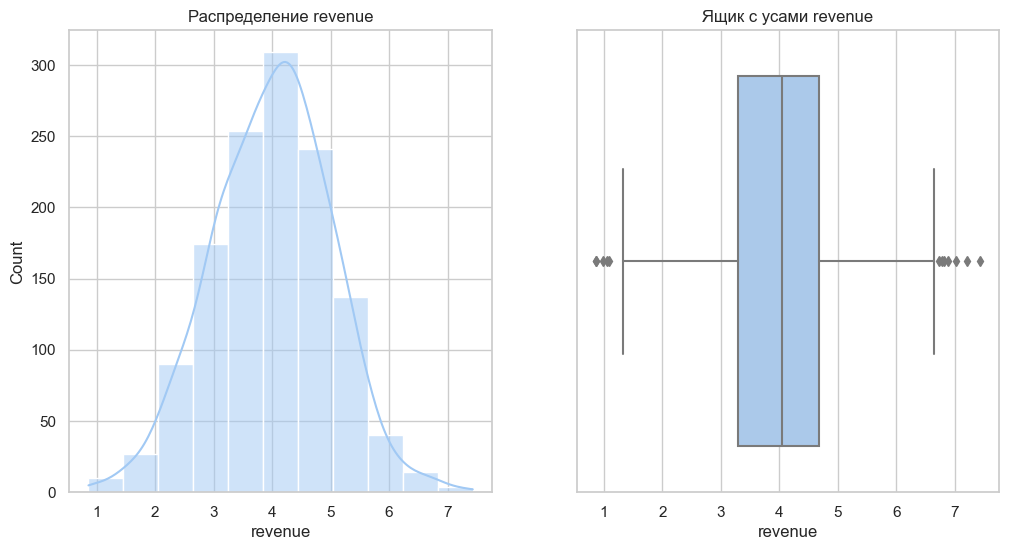

In [43]:
eda_describe_feature(money, 'revenue')

**Вывод**
- Критичные выбросы удалены
- Некоторые признаки переведены к категориальному типу

## Объединение таблиц

In [44]:
money_pivot = market_money.pivot(index='id', columns='period', values='revenue')
money_pivot.columns = [f"revenue_{col}" for col in money_pivot.columns]
money_pivot.head()

,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [45]:
time_pivot = market_time.pivot(index='id', columns='period', values='minutes')
time_pivot.columns = [f"minutes_{col}" for col in time_pivot.columns]
time_pivot.head()

,minutes_предыдущий_месяц,minutes_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [46]:
market = market_file.merge(time_pivot, on='id', how='left').merge(money_pivot, on='id', how='left')
market.head()

,id,customer_activity,service_type,allow_notification,market_activ_6_month,market_activ_curr_month,duration,promo_buys,pop_category,mean_categories_views_per_visit,unpaid_prod_unit_quarterly,service_error,pages_per_visit,promo_buys_less_0.9,minutes_предыдущий_месяц,minutes_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,1,13,14,NaN,NaN,3293.1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,1,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,0,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,0,8,11,5807.5,4594.0,5872.5


In [47]:
check_dupl_nans(market)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце customer_activity уникальных значений = 2
Список уникальных значений = ['Снизилась' 'Прежний уровень'] 

В столбце service_type уникальных значений = 2
Список уникальных значений = ['премиум' 'стандарт'] 

В столбце allow_notification уникальных значений = 2
Список уникальных значений = ['да' 'нет'] 

В столбце pop_category уникальных значений = 6
Список уникальных значений = ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 


	Количество пропущенных значений
id                                 0
customer_activity                  0
service_type                       0
allow_notification                 0
market_activ_6_month               0
market_activ_curr_month            0
duration                           0
promo_buys                         0
pop_category                       0
mean_categories_views_p

In [48]:
market.dropna(inplace=True)
market.isna().sum()

id                                 0
customer_activity                  0
service_type                       0
allow_notification                 0
market_activ_6_month               0
market_activ_curr_month            0
duration                           0
promo_buys                         0
pop_category                       0
mean_categories_views_per_visit    0
unpaid_prod_unit_quarterly         0
service_error                      0
pages_per_visit                    0
promo_buys_less_0.9                0
minutes_предыдущий_месяц           0
minutes_текущий_месяц              0
revenue_предыдущий_месяц           0
revenue_препредыдущий_месяц        0
revenue_текущий_месяц              0
dtype: int64

## Корреляционный анализ

In [49]:
# Для работы phik_matrix переведем типы object в category
#for col in market.select_dtypes(include='object').columns:
 #   market[col] = market[col].astype('category')

In [50]:
check_dupl_nans(market)


	Количество полных дубликатов = 0

	Поиск неявных дубликатов
В столбце customer_activity уникальных значений = 2
Список уникальных значений = ['Снизилась' 'Прежний уровень'] 

В столбце service_type уникальных значений = 2
Список уникальных значений = ['премиум' 'стандарт'] 

В столбце allow_notification уникальных значений = 2
Список уникальных значений = ['да' 'нет'] 

В столбце pop_category уникальных значений = 6
Список уникальных значений = ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Кухонная посуда' 'Техника для красоты и здоровья'
 'Мелкая бытовая техника и электроника'] 


	Количество пропущенных значений
id                                 0
customer_activity                  0
service_type                       0
allow_notification                 0
market_activ_6_month               0
market_activ_curr_month            0
duration                           0
promo_buys                         0
pop_category                       0
mean_categories_views_p

In [51]:
# market_clean = market.drop(columns='id').select_dtypes(include=[int, float, 'category'])
corr_matrix = market.drop(columns='id').phik_matrix()

interval columns not set, guessing: ['market_activ_6_month', 'market_activ_curr_month', 'duration', 'promo_buys', 'mean_categories_views_per_visit', 'unpaid_prod_unit_quarterly', 'service_error', 'pages_per_visit', 'promo_buys_less_0.9', 'minutes_предыдущий_месяц', 'minutes_текущий_месяц', 'revenue_предыдущий_месяц', 'revenue_препредыдущий_месяц', 'revenue_текущий_месяц']


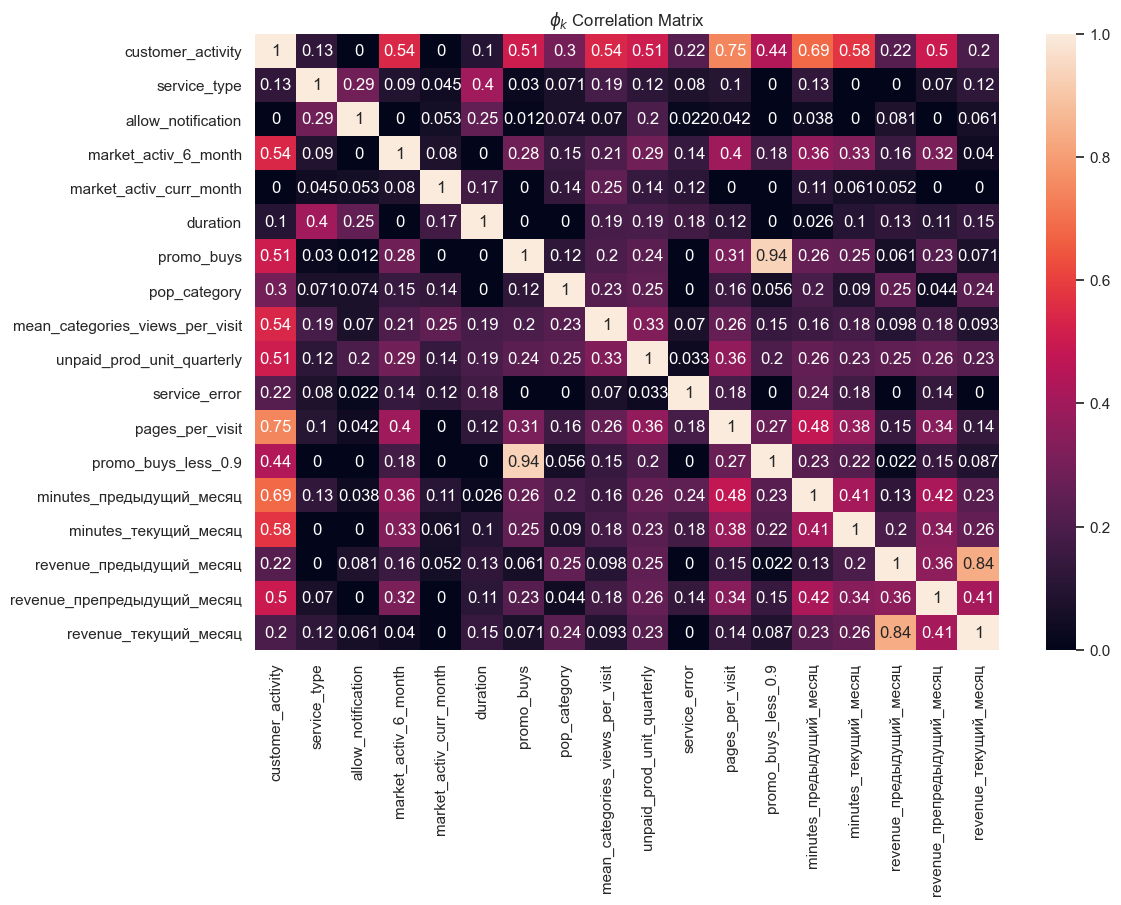

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('$\phi_k$ Correlation Matrix')
plt.show()

**Вывод**

Мультиколлинеарность есть только с новым добавленным признаком, в исследовательском анализе данных для устранения мультимодальности. При обучении первоначальный признак можно не учитывать.

## Использование пайплайнов

In [53]:
X = market.drop(columns=['id', 'customer_activity'])
y = market['customer_activity']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

In [55]:
ohe_columns = ['allow_notification', 'pop_category']
ord_columns = ['service_type']
num_columns = ['market_activ_6_month', 'market_activ_curr_month', 'duration', 'mean_categories_views_per_visit', 'unpaid_prod_unit_quarterly', 'service_error', 'pages_per_visit', 'promo_buys_less_0.9', 'minutes_предыдущий_месяц', 'minutes_текущий_месяц', 'revenue_предыдущий_месяц', 'revenue_препредыдущий_месяц', 'revenue_текущий_месяц']


In [56]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [57]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [58]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[['стандарт', 'премиум']],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Выше в ohe_pipe ord_pipe стояли SimpleInputer'ы, но у меня почему-то не обучалось через рандом. Ошибка была

In [59]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ],
    remainder='passthrough'
)

In [60]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [61]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(
            kernel='linear',
            probability=True,
            random_state=RANDOM_STATE
        )],
        'models__C': [0.01, 0.1, 0.5, 1],
        #'models__gamma': [0.01, 0.1, 0.5, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [62]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=20
)
randomized_search.fit(X_train, y_train)

D:\Programs\Anaconda3\envs\practicum_base\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['allow_notification',
                                                                                'pop_category']),
                                                                              ('ord',
                                                                               Pipeline(steps=...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='linear',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': [0.01, 0.1, 0.5, 1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Метрика **ROC-AUC** выбрана потому, что
- независит от порога, метрика ROC-AUC измеряет качество модели по всей шкале вероятностей, а не только по порогу 0.5.
- поддерживает дисбаланс классов (например, 95% негативных, 5% позитивных) accuracy может врать, а ROC-AUC останется адекватной метрикой. Она смотрит на качество ранжирования: насколько правильно модель отделяет положительные от отрицательных классов.
- хорошо работает для всех моделей в пайплайне (KNN, LogisticRegression, SVC, DecisionTree), так как они поддерживают predict_proba()

In [63]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['allow_notification',
                                                   'pop_category']),
                                                 ('ord',
                                         

In [64]:
probabilities = randomized_search.predict_proba(X_test)
y_pred_probabilities = probabilities[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_probabilities )}')

Метрика ROC-AUC на тестовой выборке: 0.920236217287546


## Анализ важности признаков

In [65]:
best_model = randomized_search.best_estimator_

preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['models']

X_preprocessed = preprocessor.transform(X_test)

explainer = shap.LinearExplainer(model, X_preprocessed)
shap_values = explainer.shap_values(X_preprocessed)

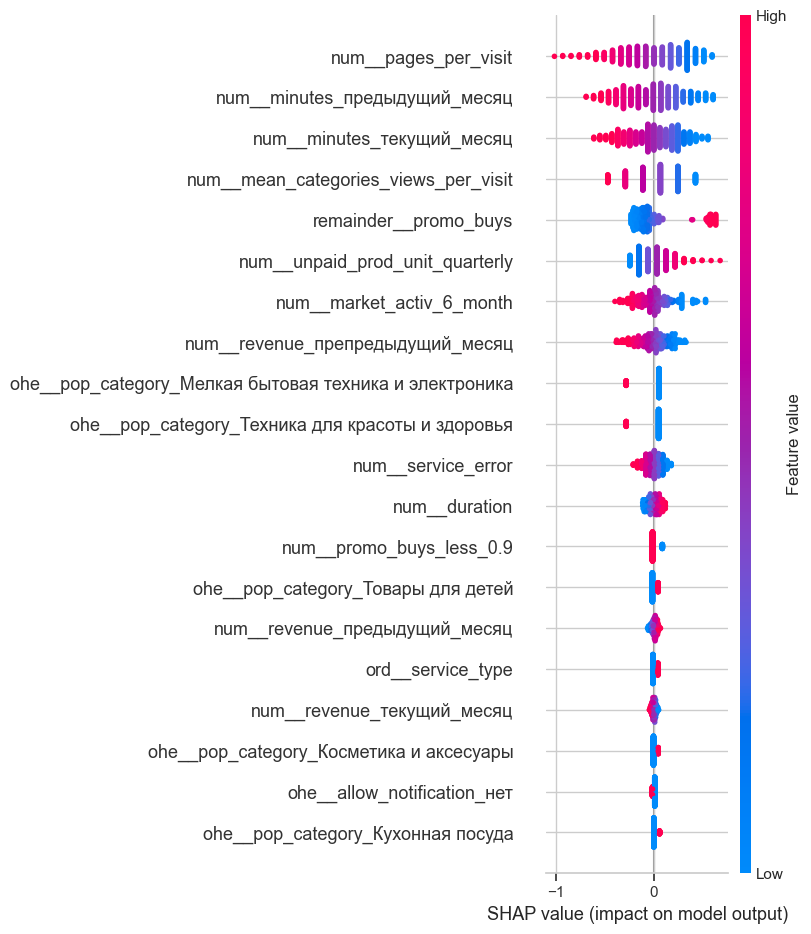

In [66]:
# Для хранения финальных имён фич
feature_names = preprocessor.get_feature_names_out().tolist()
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)

**Выводы о значимости признаков**
- Признаки мало значимые для модели:
    - _"Популярная категория - Кухонная посуда"_,
    - _"Разрешить сообщать - нет"_,
    - _"Популярная категория - Косметика и аксесуары"_,
    - _"Выручка за текущий месяц"_,
    - _"Тип сервиса"_,
    - _"Выручка за предыдущий месяц"_,
    - _"Популярная категория - Товары для детей"._

dУ них shap значения очень близки к 0 и маленький разброс точек.

- Признаки, которые сильнее всего влияют на целевой признак:
    - _"Страниц за визит"_,
    - _"Минут предыдущий месяц"_,
    - _"Минут текущий месяц"_,
    - _"Средний просмотр категорий за визит"_,
    - _"Акционные покупки"._

У них наибольший разброс по оси $X$. Признаки: _"Страниц за визит", "Минут предыдущий месяц", "Минут текущий месяц", "Средний просмотр категорий за визит"_ имеют больше значений в отрицательной стороне, что склоняет модель отнести объекты к классу 0, у _"Акционные покупки"_ - в положительную, то есть к классу 1.
- Можно убрать признаки с низкой значимостью (низкий SHAP) модель станет проще, быстрее, и не потеряет качество, в то же время сфокусироваться на самых важных признаках, чтобы моделировать и принимать бизнес-решения

## Сегментация покупателей

In [67]:
market_full = market.merge(money, on='id', how='left')
market_full.head()

,id,customer_activity,service_type,allow_notification,market_activ_6_month,market_activ_curr_month,duration,promo_buys,pop_category,mean_categories_views_per_visit,unpaid_prod_unit_quarterly,service_error,pages_per_visit,promo_buys_less_0.9,minutes_предыдущий_месяц,minutes_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц,revenue
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1,12,10,5216.0,4472.0,4971.6,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,1,8,13,5457.5,4826.0,5058.4,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,0,11,13,6158.0,4793.0,6610.4,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,0,8,11,5807.5,4594.0,5872.5,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,1,10,10,4738.5,5124.0,5388.5,3.95


In [68]:
market_full.isna().sum()

id                                 0
customer_activity                  0
service_type                       0
allow_notification                 0
market_activ_6_month               0
market_activ_curr_month            0
duration                           0
promo_buys                         0
pop_category                       0
mean_categories_views_per_visit    0
unpaid_prod_unit_quarterly         0
service_error                      0
pages_per_visit                    0
promo_buys_less_0.9                0
minutes_предыдущий_месяц           0
minutes_текущий_месяц              0
revenue_предыдущий_месяц           0
revenue_препредыдущий_месяц        0
revenue_текущий_месяц              0
revenue                            0
dtype: int64

### Сегментация покупателей

In [69]:
market_full['risk'] = best_model.predict_proba(X)[:, 1]
market_full['revenue_segment'] = pd.qcut(market_full['revenue'], 2, labels=['low', 'high'])
market_full['risk_segment'] = pd.cut(market_full['risk'], bins=[0, 0.5, 1], labels=['low', 'high'])


### Сегментация покупателей

In [70]:
market_full['risk'] = best_model.predict_proba(X)[:, 1]
market_full['revenue_segment'] = pd.qcut(market_full['revenue'], 2, labels=['low', 'high'])
market_full['risk_segment'] = pd.cut(market_full['risk'], bins=[0, 0.5, 1], labels=['low', 'high'])

market_full['segment'] = market_full['risk_segment'].astype(str) + '_' + market_full['revenue_segment'].astype(str)
market_full.head()

,id,customer_activity,service_type,allow_notification,market_activ_6_month,market_activ_curr_month,duration,promo_buys,pop_category,mean_categories_views_per_visit,...,minutes_предыдущий_месяц,minutes_текущий_месяц,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц,revenue,risk,revenue_segment,risk_segment,segment
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,12,10,5216.0,4472.0,4971.6,4.16,0.911231,high,high,high_high
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,8,13,5457.5,4826.0,5058.4,3.13,0.433845,low,low,low_low
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,11,13,6158.0,4793.0,6610.4,4.87,0.814155,high,high,high_high
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,8,11,5807.5,4594.0,5872.5,4.21,0.970787,high,high,high_high
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,10,10,4738.5,5124.0,5388.5,3.95,0.675066,low,high,high_low


### Выбор группы покупателей

In [71]:
market_full['segment_high'] = np.where(market_full['segment'] == 'high_high', 'high_risk', 'others')

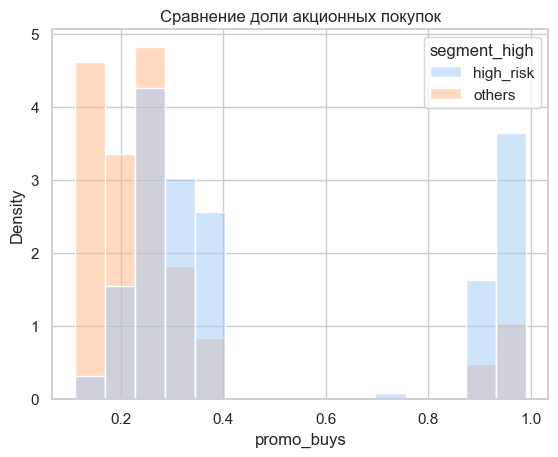

In [72]:
sns.histplot(data=market_full, x='promo_buys', hue='segment_high', bins=15, kde=False, stat="density", common_norm=False)
plt.title("Сравнение доли акционных покупок")
plt.show()

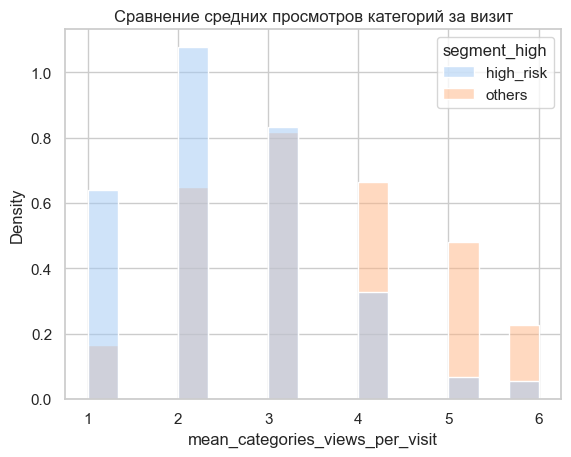

In [73]:
sns.histplot(data=market_full, x='mean_categories_views_per_visit', hue='segment_high',
             bins=15, kde=False, stat="density", common_norm=False)
plt.title("Сравнение средних просмотров категорий за визит")
plt.show()

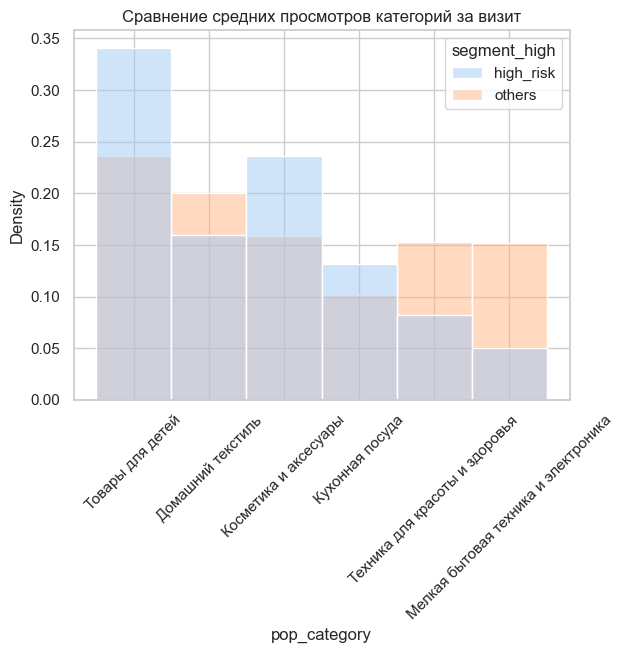

In [74]:
sns.histplot(data=market_full, x='pop_category', hue='segment_high', bins=15, kde=False,
             stat="density", common_norm=False)
plt.title("Сравнение средних просмотров категорий за визит")
plt.xticks(rotation=45)
plt.show()

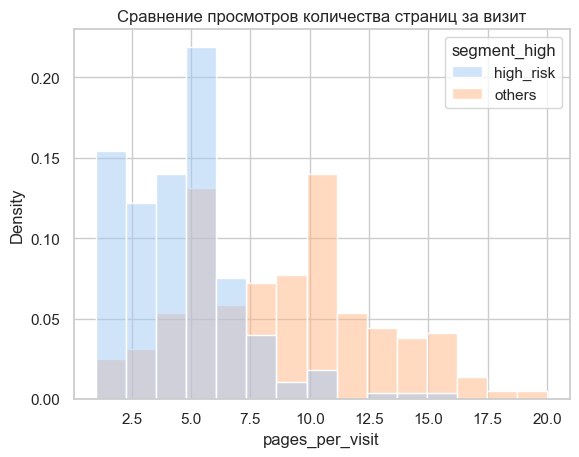

In [75]:
sns.histplot(data=market_full, x='pages_per_visit', hue='segment_high', bins=15, kde=False,
             stat="density", common_norm=False)
plt.title("Сравнение просмотров количества страниц за визит")
plt.show()

**Выводы**

_Сравнение доли акционных покупок_
- Группа `high_risk` чаще совершает покупки по акциям. У них заметно больше плотности в районе значений 0.9–1.0 по promo_buys. \
Особенно выражен пик на 1.0, то есть часть клиентов почти всегда покупает по акции.
- Группа `others` — менее чувствительна к акциям. Плотность сосредоточена в диапазоне 0.15–0.35, то есть они делают акционные покупки реже.

_Сравнение средних просмотров категорий за визит_
- Группа `high_risk` имеет больше плотности в районе значения - 2. Для этой группы самыми популярными категориями являются - "Товары для детей", "Косметика и аксесуары"
- Группа `others` имеет распределение близкое к нормальному и самое большое значение в районе "3". Сами категории распределены примерно равномерно, самая популярная - "Товары для детей"

_Сравнение просмотров количества страниц за визит_
- Группа `high_risk` имеет пик вокруг значения - 5. Большинство пользователей этой группы смотрят первые 5 страниц, и почти никогда не доходят до 20 страницы
- Группа `others` имеет распределение близкое к нормальному с пиками вокруг 5 и 10.

### Выводы о сегментах

- Выбранный сегмент:

Клиенты с высокой вероятностью снижения активности и высокой прибыльностью (high risk, high profit). Сегмент выбранных клиентов зависим от промо-акций

- Почему выбрали:

Это самые ценные, но нестабильные клиенты их потеря особенно болезненна

- Предложенные действия:
    - Запустить персонализированные акции на категории "Товары для детей", "Косметика и аксесуары".
    - Добавить ограниченные по времени предложения, чтобы стимулировать срочные покупки.
    - Разместить баннеры/рекомендации с упором на товары категории "Товары для детей", "Косметика и аксесуары" на главной странице или в письмах.
    - Разместить популярные товары из интересующих категорий на первых 5 страницах.
    - Добавить индивидуальные рекомендации на первой странице.

## Общий вывод

- **Задача** - разработать модель, которая предскажет вероятность снижения покупательской активности, а также выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.
- **Исходные данные** - таблицы, которые содержат данные о поведении покупателя на сайте, о коммуникациях с покупателем и их продуктовом поведении, о выручке, о времени, которое покупатель провел на сайте.
- Предобработка включила в себя исправление опечатки и устранение неявных дубликатов, типы данных в норме и пропущенных значений тоже нет;
- Для поиска лучшей модели использовался случайный поиск кросс-валидации, состоящий из 4 моделей с различными параметрами, главной метрикой выбрана - roc-auc, так как она устойчива, чтобы сравнивать разные модели, не зависит от выбора конкретного порога классификации;
- Лучшая модель - **SVC**;
- Выбранный сегмент: Клиенты с высокой вероятностью снижения активности и высокой прибыльностью (high risk, high profit). Даже внутри прибыльного сегмента большая часть клиентов не генерирует сверхвысокую выручку. Основная масса — "среднеприбыльные", но с высоким риском ухода
- Предложенные действия:
    - Запустить персонализированные акции на категории "Товары для детей", "Косметика и аксесуары".
    - Добавить ограниченные по времени предложения, чтобы стимулировать срочные покупки.
    - Разместить баннеры/рекомендации с упором на товары категории "Товары для детей", "Косметика и аксесуары" на главной странице или в письмах.
    - Разместить популярные товары из интересующих категорий на первых 5 страницах.
    - Добавить индивидуальные рекомендации на первой странице.